In [1]:
import pandas as pd
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pykalman import KalmanFilter
from joblib import Parallel, delayed

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import stats

## Data Cleaning

In [2]:
balancing_df = pd.read_csv("./Data/balancing_data.csv", )
demand_load_df = pd.read_csv("./Data/demand_load_data.csv")
generation_df = pd.read_csv("./Data/generation_data.csv")
price_df = pd.read_csv("./Data/price_data.csv")

In [3]:
balancing_df = balancing_df.set_index(pd.to_datetime(balancing_df["GMT Time"])).drop(columns=["GMT Time"])
demand_load_df = demand_load_df.set_index(pd.to_datetime(demand_load_df["GMT Time"])).drop(columns=["GMT Time"])
generation_df = generation_df.set_index(pd.to_datetime(generation_df["GMT Time"])).drop(columns=["GMT Time"])
price_df = price_df.set_index(pd.to_datetime(price_df["GMT Time"])).drop(columns=["GMT Time"])

final_data = pd.merge(balancing_df, price_df, left_index=True, right_index=True).join(generation_df, how="left").join(demand_load_df, how="left")
final_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 23 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   System Price (ESO Outturn) - GB (£/MWh)                                           118320 non-null  object 
 1   NIV Outturn (+ve long) - GB (MW)                                                  118320 non-null  float64
 2   BM Bid Acceptances (total) - GB (MW)                                              118320 non-null  object 
 3   BM Offer Acceptances (total) - GB (MW)                                            118320 non-null  object 
 4   Total BSAD Volume - Turn Up - GB (MW)                                             118320 non-null  object 
 5   Total BSAD Volume - Turn Down - GB (MW)                           

In [4]:
list(final_data.columns).sort() == (list(price_df.columns) + list(demand_load_df.columns) + list(generation_df.columns) + list(balancing_df.columns)).sort()

True

In [5]:
columns_metadata = [

    {"short_name": "system_price", "category": "Pricing", 

     "original_name": "System Price (ESO Outturn) - GB (£/MWh)", 

     "description": "The outturn system price determined by the ESO for balancing actions."},

    

    {"short_name": "niv_outturn", "category": "Demand", 

     "original_name": "NIV Outturn (+ve long) - GB (MW)", 

     "description": "Net Imbalance Volume indicating system balance (+ve long = surplus)."},

    

    {"short_name": "bm_bid_accept", "category": "Supply", 

     "original_name": "BM Bid Acceptances (total) - GB (MW)", 

     "description": "Total volume of bids accepted in the Balancing Mechanism."},

    

    {"short_name": "bm_offer_accept", "category": "Supply", 

     "original_name": "BM Offer Acceptances (total) - GB (MW)", 

     "description": "Total volume of offers accepted in the Balancing Mechanism."},

    

    {"short_name": "bsad_turn_up", "category": "Supply", 

     "original_name": "Total BSAD Volume - Turn Up - GB (MW)", 

     "description": "Volume of upward balancing service adjustment actions."},

    

    {"short_name": "bsad_turn_down", "category": "Demand", 

     "original_name": "Total BSAD Volume - Turn Down - GB (MW)", 

     "description": "Volume of downward balancing service adjustment actions."},

    

    {"short_name": "bsad_total", "category": "Supply", 

     "original_name": "Total BSAD Volume - Total - GB (MW)", 

     "description": "Total volume of balancing service adjustment actions."},

    

    {"short_name": "intraday_volume", "category": "Supply", 

     "original_name": "Intraday Volume (EPEX Outturn, APX, MID) - GB (MWh)", 

     "description": "Total traded volume in the intraday market."},

    

    {"short_name": "day_ahead_price", "category": "Pricing", 

     "original_name": "Day Ahead Price (EPEX half-hourly, local) - GB (LC/MWh)", 

     "description": "Half-hourly price for electricity in the Day-Ahead Market."},

    

    {"short_name": "intraday_price", "category": "Pricing", 

     "original_name": "Intraday Price (EPEX Outturn, APX, MID) - GB (£/MWh)", 

     "description": "Price of electricity in the Intraday Market."},

    

    {"short_name": "gen_biomass", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Biomass - GB (MW)", 

     "description": "Actual aggregated generation from biomass sources."},

    

    {"short_name": "gen_fossil_gas", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Fossil Gas - GB (MW)", 

     "description": "Actual aggregated generation from fossil gas sources."},

    

    {"short_name": "gen_hard_coal", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Fossil Hard Coal - GB (MW)", 

     "description": "Actual aggregated generation from fossil hard coal sources."},

    

    {"short_name": "gen_oil", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Fossil Oil - GB (MW)", 

     "description": "Actual aggregated generation from fossil oil sources."},

    

    {"short_name": "gen_pumped_hydro", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Hydro Pumped Storage - GB (MW)", 

     "description": "Actual aggregated generation from pumped storage hydro sources."},

    

    {"short_name": "gen_hydro_ror", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Hydro Run-of-River and Poundage - GB (MW)", 

     "description": "Actual aggregated generation from run-of-river hydro sources."},

    

    {"short_name": "gen_nuclear", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Nuclear - GB (MW)", 

     "description": "Actual aggregated generation from nuclear sources."},

    

    {"short_name": "gen_solar", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Solar - GB (MW)", 

     "description": "Actual aggregated generation from solar sources."},

    

    {"short_name": "gen_wind_onshore", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Wind Onshore - GB (MW)", 

     "description": "Actual aggregated generation from onshore wind sources."},

    

    {"short_name": "gen_wind_offshore", "category": "Generation", 

     "original_name": "Actual Aggregated Generation By Type - Wind Offshore - GB (MW)", 

     "description": "Actual aggregated generation from offshore wind sources."},

    

    {"short_name": "load_prob", "category": "Demand", 

     "original_name": "Loss of Load Probability - Latest - GB ()", 

     "description": "Probability of a loss of load occurring at a given time."},

    

    {"short_name": "total_load", "category": "Demand", 

     "original_name": "Actual Total Load - GB (MW)", 

     "description": "Actual total load demand across the grid."},

    

    {"short_name": "demand_outturn", "category": "Demand", 

     "original_name": "Demand Outturn (ITSDO) - GB (MW)", 

     "description": "Actual demand outturn in MW for the given time period."}

]



# Convert to a pandas dataframe

metadata_df = pd.DataFrame(columns_metadata)


In [6]:
rename_dict = {
    "System Price (ESO Outturn) - GB (£/MWh)": "system_price",
    "NIV Outturn (+ve long) - GB (MW)": "niv_outturn",
    "BM Bid Acceptances (total) - GB (MW)": "bm_bid_accept",
    "BM Offer Acceptances (total) - GB (MW)": "bm_offer_accept",
    "Total BSAD Volume - Turn Up - GB (MW)": "bsad_turn_up",
    "Total BSAD Volume - Turn Down - GB (MW)": "bsad_turn_down",
    "Total BSAD Volume - Total - GB (MW)": "bsad_total",
    "Intraday Volume (EPEX Outturn, APX, MID) - GB (MWh)": "intraday_volume",
    "Day Ahead Price (EPEX half-hourly, local) - GB (LC/MWh)": "day_ahead_price",
    "Intraday Price (EPEX Outturn, APX, MID) - GB (£/MWh)": "intraday_price",
    "Actual Aggregated Generation By Type - Biomass - GB (MW)": "gen_biomass",
    "Actual Aggregated Generation By Type - Fossil Gas - GB (MW)": "gen_fossil_gas",
    "Actual Aggregated Generation By Type - Fossil Hard Coal - GB (MW)": "gen_hard_coal",
    "Actual Aggregated Generation By Type - Fossil Oil - GB (MW)": "gen_oil",
    "Actual Aggregated Generation By Type - Hydro Pumped Storage - GB (MW)": "gen_pumped_hydro",
    "Actual Aggregated Generation By Type - Hydro Run-of-River and Poundage - GB (MW)": "gen_hydro_ror",
    "Actual Aggregated Generation By Type - Nuclear - GB (MW)": "gen_nuclear",
    "Actual Aggregated Generation By Type - Solar - GB (MW)": "gen_solar",
    "Actual Aggregated Generation By Type - Wind Onshore - GB (MW)": "gen_wind_onshore",
    "Actual Aggregated Generation By Type - Wind Offshore - GB (MW)": "gen_wind_offshore",
    "Loss of Load Probability - Latest - GB ()": "load_prob",
    "Actual Total Load - GB (MW)": "total_load",
    "Demand Outturn (ITSDO) - GB (MW)": "demand_outturn",
}

# Rename the columns in the dataframe
final_data = final_data.rename(columns=rename_dict)

In [7]:
final_data.to_csv("./Data/Master_Dataset.csv")
metadata_df.to_csv("./Data/Variable_Medatadata.csv")

#### Checking for Empty Values

In [8]:
final_data =  final_data.apply(pd.to_numeric, errors='coerce')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   system_price       118275 non-null  float64
 1   niv_outturn        118320 non-null  float64
 2   bm_bid_accept      117768 non-null  float64
 3   bm_offer_accept    116849 non-null  float64
 4   bsad_turn_up       62465 non-null   float64
 5   bsad_turn_down     47406 non-null   float64
 6   bsad_total         81271 non-null   float64
 7   intraday_volume    117680 non-null  float64
 8   day_ahead_price    118256 non-null  float64
 9   intraday_price     117680 non-null  float64
 10  gen_biomass        116125 non-null  float64
 11  gen_fossil_gas     116125 non-null  float64
 12  gen_hard_coal      116125 non-null  float64
 13  gen_oil            116125 non-null  float64
 14  gen_pumped_hydro   116125 non-null  float64
 15  gen_hydro_ror    

In [9]:
timeseries = pd.Series(final_data['system_price'])
timeseries.to_csv('Data/timeseries.csv')

## EDA

In [10]:
data = final_data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   system_price       118275 non-null  float64
 1   niv_outturn        118320 non-null  float64
 2   bm_bid_accept      117768 non-null  float64
 3   bm_offer_accept    116849 non-null  float64
 4   bsad_turn_up       62465 non-null   float64
 5   bsad_turn_down     47406 non-null   float64
 6   bsad_total         81271 non-null   float64
 7   intraday_volume    117680 non-null  float64
 8   day_ahead_price    118256 non-null  float64
 9   intraday_price     117680 non-null  float64
 10  gen_biomass        116125 non-null  float64
 11  gen_fossil_gas     116125 non-null  float64
 12  gen_hard_coal      116125 non-null  float64
 13  gen_oil            116125 non-null  float64
 14  gen_pumped_hydro   116125 non-null  float64
 15  gen_hydro_ror    

## Model Creation System Price
A sarima model was employed with the exogenous variable "day_ahead_price". Experiments were carried out, employing a Kalman filter to smooth the data. However it did not result in an improvement. As such it was ommitted from the final notebook.

In [45]:
selected = data[['day_ahead_price']]

# Get the latest date in the index
latest_date = selected.index.max()

# Calculate the date 365 days before the latest date
start_date = latest_date - pd.Timedelta(days=28)

selected = selected[selected.index >= start_date]

selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2024-09-02 23:30:00 to 2024-09-30 23:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day_ahead_price  1345 non-null   float64
dtypes: float64(1)
memory usage: 21.0 KB


In [12]:

# Get the latest date in the index
latest_date = selected.index.max()

# Calculate the date 365 days before the latest date
start_date = latest_date - pd.Timedelta(hours=23.5)

selected_48 = selected[selected.index >= start_date]

selected_48.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2024-09-30 00:00:00 to 2024-09-30 23:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day_ahead_price  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [13]:
ts = data['system_price']
y = ts
y.index = pd.to_datetime(y.index)
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Series name: system_price
Non-Null Count   Dtype  
--------------   -----  
118275 non-null  float64
dtypes: float64(1)
memory usage: 5.8 MB


In [14]:
#y = y[y['system_price'] != 0]
y = y.dropna()
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 118275 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Series name: system_price
Non-Null Count   Dtype  
--------------   -----  
118275 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [15]:
y = y.replace(0, 1e-10)

In [16]:
# Get the latest date in the index
latest_date = y.index.max()

# Calculate the date 365 days before the latest date
start_date = latest_date - pd.Timedelta(days=28)

y_week = y[y.index >= start_date]

y_week.tail()

GMT Time
2024-09-30 21:30:00    57.40
2024-09-30 22:00:00    62.78
2024-09-30 22:30:00    29.50
2024-09-30 23:00:00    52.88
2024-09-30 23:30:00    48.27
Name: system_price, dtype: float64

#### Daily Seasonality

In [17]:
# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y_week,maxlag=96) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 48 # season parameter 
d = ndiffs(y_week, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y_week, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: -11.854660307816678
p-value: 7.074432073370222e-22
Regular differences:  0
Seasonal differences: 0


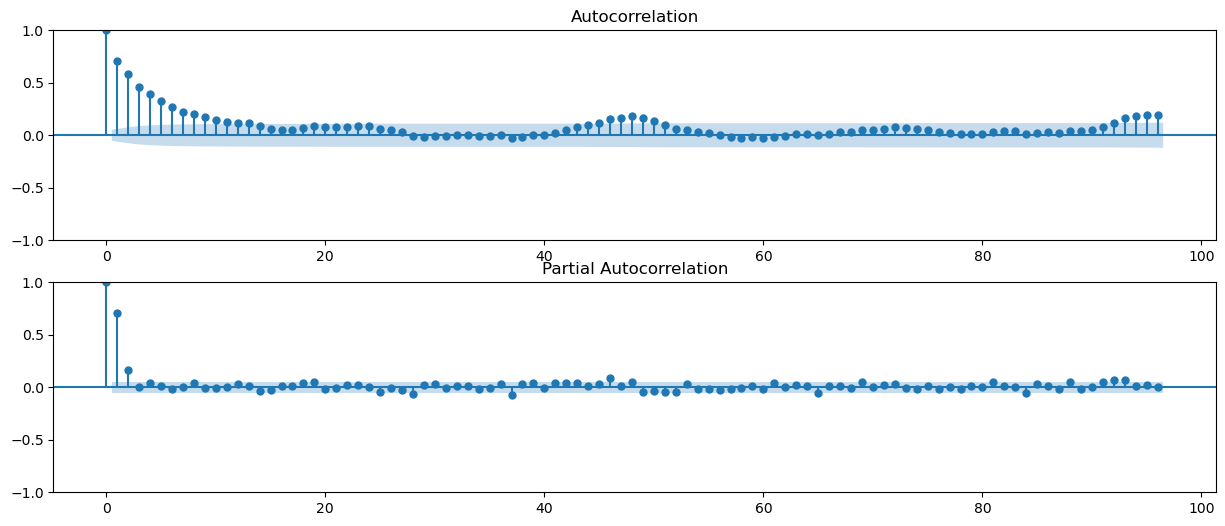

In [18]:
nlags = 96 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y_week, lags = nlags, ax=ax[0])
plot_pacf(y_week, lags = nlags, method="ols", ax=ax[1])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63657D+00    |proj g|=  1.99801D-02


 This problem is unconstrained.



At iterate    5    f=  4.63606D+00    |proj g|=  4.39859D-03

At iterate   10    f=  4.63601D+00    |proj g|=  2.17929D-03

At iterate   15    f=  4.63574D+00    |proj g|=  1.17228D-02

At iterate   20    f=  4.63547D+00    |proj g|=  1.07230D-03

At iterate   25    f=  4.63538D+00    |proj g|=  5.45096D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   1.442D-05   4.635D+00
  F =   4.6353823104724228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

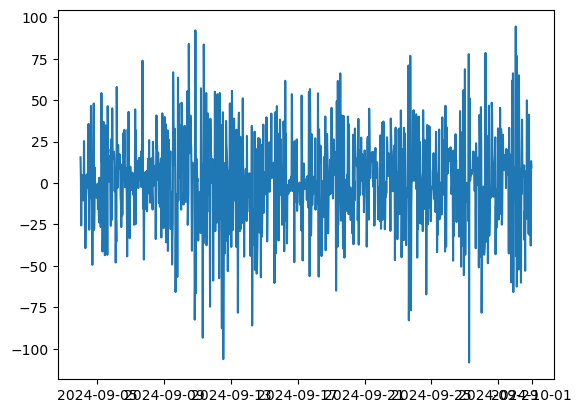

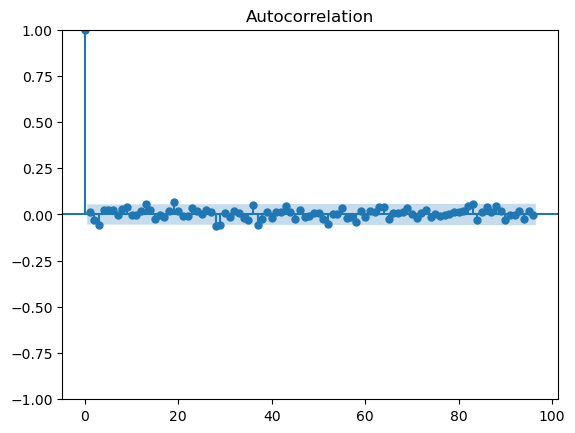

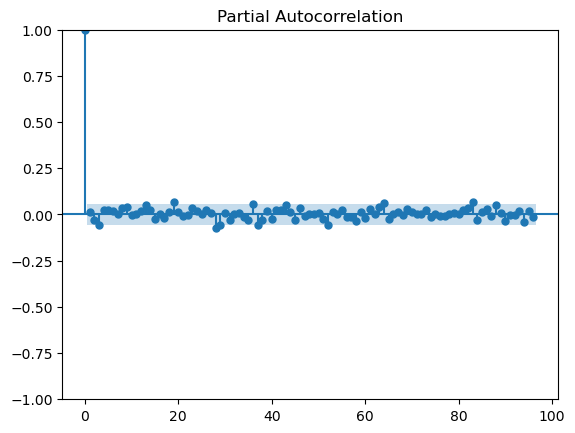

ADF Statistic: -22.21540858374913
p-value: 0.0
Critical Values:
   1%: -3.4354175403897727
   5%: -2.8637778952086848
   10%: -2.5679614713589562


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

s = 48

#fit = SARIMAX(endog = y_week, order = (2,0,0), seasonal_order = (0,0,0,s)).fit()
#fit = SARIMAX(endog = y_week, order = (3,0,1), seasonal_order = (0,0,0,s)).fit()
fit = SARIMAX(endog = y_week, exog = selected,order = (1,0,1), seasonal_order = (1,0,1,s)).fit()


print(fit.summary())
residuos = fit.resid[s+1:]

nlags=96

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()


# Run ADF test on the residuals
adf_test = sm.tsa.stattools.adfuller(residuos)

# Extract and print ADF test results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

In [20]:
# t-test for the mean with Ho equal to zero

t_statistic, p_value = stats.ttest_1samp(residuos, 0)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 1.114857840792945
P-value: 0.2651181967950124


Ljung-Box for the residuals
      lb_stat  lb_pvalue
96  91.530267    0.61003
Shapiro test for residuals: Statistic value 0.9798558354377747 p-value 1.8015007888227963e-12


/var/folders/fs/d_m9l_fs169d2k37mxblsk400000gn/T/ipykernel_51060/2134962675.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(residuos, hist = False, kde = True,
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


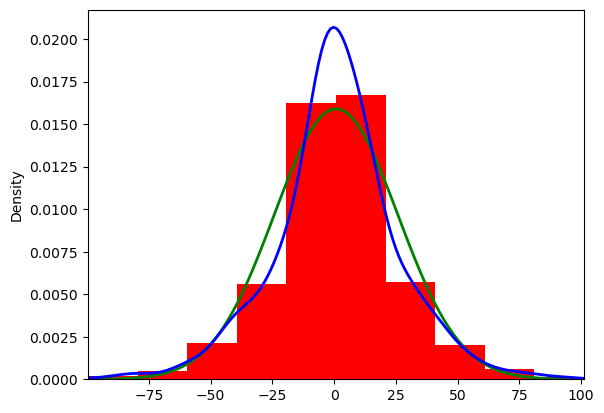

In [21]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[96])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

Ljung-Box for squared residuals
       lb_stat     lb_pvalue
96  222.357246  5.012040e-12


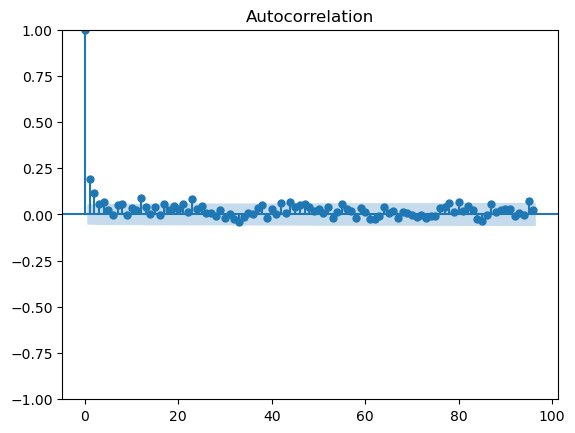

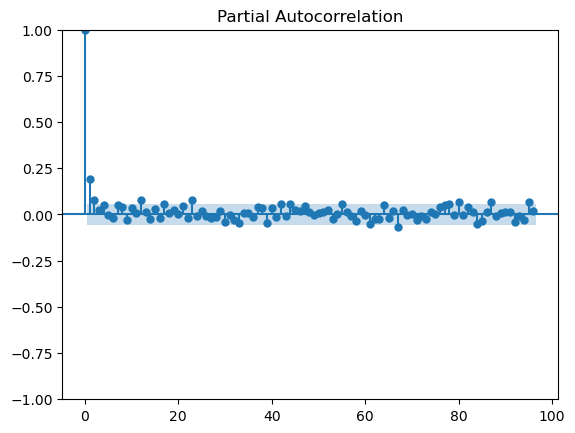

In [22]:
# Study the squared residuals for SWN

box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[96])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuos**2,lags=nlags)
plt.show()
plot_pacf(residuos**2,lags=nlags,method="ols")
plt.show()

In [23]:
y_pred = fit.forecast(steps = 48, exog = selected_48)
y_pred = pd.DataFrame(y_pred)

In [24]:
from arch import arch_model

#garch_model = arch_model(residuos, mean='constant', vol='ARCH', p=3)
garch_model = arch_model(residuos, mean='constant', vol='EGARCH', p=1, q=1)

garch_fit = garch_model.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 406101188.8766039
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11133.836120758791
Iteration:      3,   Func. Count:     22,   Neg. LLF: 5999.8200993158425
Iteration:      4,   Func. Count:     28,   Neg. LLF: 5989.679742560906
Iteration:      5,   Func. Count:     34,   Neg. LLF: 5985.268169518142
Iteration:      6,   Func. Count:     39,   Neg. LLF: 5985.266318792381
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5985.266278517249
Iteration:      8,   Func. Count:     49,   Neg. LLF: 5985.266275890284
Iteration:      9,   Func. Count:     53,   Neg. LLF: 5985.266275890619
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5985.266275890284
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5985.27
Distribution:                  Normal   AIC:                           11978.5
Method:            Maximum Likelihood   BIC:                           11999.2
                                        No. Observations:                 1296
Date:                Thu, Dec 05 2024   Df Residuals:                     1295
Time:                        13:49:43   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.3785      0.776      1.776  7.568e-02 [ -0.143,  2.900]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.5363      1.857      1.366      0.172   [ -1.103,  6.176]
alpha[1]       0.2948  9.606e-02      3.069  2.150e-03   [  0.107,  0.483]
beta[1]        0.6067      0.289      2.097  3.596e-02 [3.975e-02,  1.174]
==========================================================================

Covariance estimator: robust
"""

In [25]:
y_pred_series = y_pred.iloc[:, 0]  # Use the first column of the DataFrame
# Forecast for the next 10 steps
garch_forecast = garch_fit.forecast(horizon=48, method='simulation')

# Access the mean and variance forecasts
garch_residual_forecast = garch_forecast.mean.iloc[-1].values  # Forecasted mean
garch_variance_forecast = garch_forecast.variance.iloc[-1].values  # Forecasted variance

# Compute the volatility forecast if needed (square root of variance)
volatility_forecast = np.sqrt(garch_variance_forecast)

# Final combined forecast (SARIMA + GARCH)
final_forecast = y_pred_series + volatility_forecast

# Print outputs
print("SARIMA Forecast:", y_pred_series)
print("GARCH Residual Forecast (Mean):", garch_residual_forecast)
print("GARCH Volatility Forecast:", volatility_forecast)
print("Final Combined Forecast:", final_forecast)

SARIMA Forecast: 2024-10-01 00:00:00      2.943112
2024-10-01 00:30:00      6.506390
2024-10-01 01:00:00      2.982328
2024-10-01 01:30:00     -2.452622
2024-10-01 02:00:00     10.883554
2024-10-01 02:30:00      7.011409
2024-10-01 03:00:00      8.207396
2024-10-01 03:30:00      9.909760
2024-10-01 04:00:00     29.049735
2024-10-01 04:30:00     42.264438
2024-10-01 05:00:00     64.016464
2024-10-01 05:30:00     76.041595
2024-10-01 06:00:00     78.595146
2024-10-01 06:30:00     84.172217
2024-10-01 07:00:00     83.653166
2024-10-01 07:30:00     70.618125
2024-10-01 08:00:00     86.501132
2024-10-01 08:30:00     83.379087
2024-10-01 09:00:00     91.027267
2024-10-01 09:30:00     92.441884
2024-10-01 10:00:00     92.923359
2024-10-01 10:30:00     94.840296
2024-10-01 11:00:00     96.665121
2024-10-01 11:30:00     94.982244
2024-10-01 12:00:00     92.955283
2024-10-01 12:30:00     90.283381
2024-10-01 13:00:00     84.724127
2024-10-01 13:30:00     80.756119
2024-10-01 14:00:00     79.8569

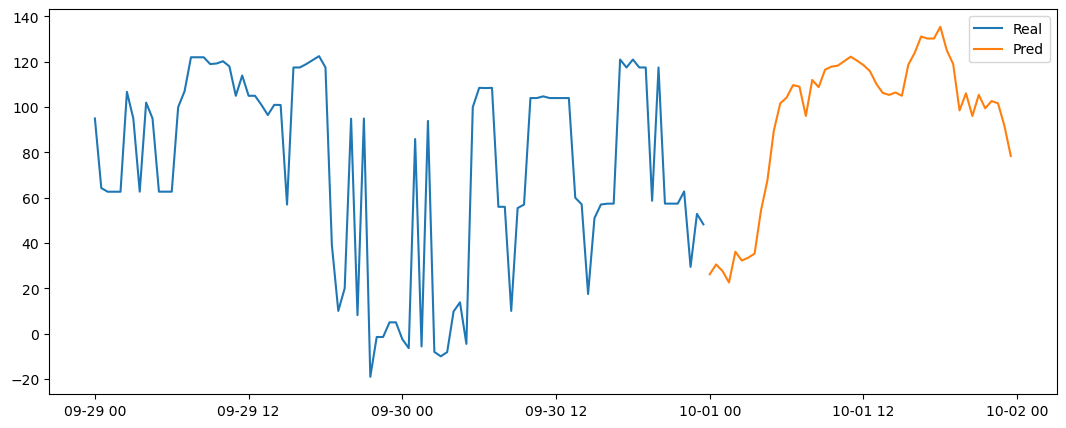

In [26]:
# Keep only the last 96 entries
y_last_96 = y.iloc[-96:]
y_pred_last_96 = final_forecast

# Plot the shortened data
plt.figure(figsize=(13, 5))
plt.plot(y_last_96, label='Real')
plt.plot(y_pred_last_96, label='Pred')
plt.legend()
plt.show()

In [27]:
final_forecast = pd.DataFrame(final_forecast)
final_forecast = final_forecast.rename(columns={'predicted_mean': 'system_price'})

## Model Creation NIV

In [28]:
selected = data[['demand_outturn']]

# Get the latest date in the index
latest_date = selected.index.max()

# Calculate the date 365 days before the latest date
start_date = latest_date - pd.Timedelta(days=28)

selected = selected[selected.index >= start_date]

selected.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2024-09-02 23:30:00 to 2024-09-30 23:30:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   demand_outturn  1345 non-null   float64
dtypes: float64(1)
memory usage: 21.0 KB


In [29]:

# Get the latest date in the index
latest_date = selected.index.max()

# Calculate the date 365 days before the latest date
start_date = latest_date - pd.Timedelta(hours=23.5)

selected_48 = selected[selected.index >= start_date]

selected_48.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2024-09-30 00:00:00 to 2024-09-30 23:30:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   demand_outturn  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [30]:
ts = data['niv_outturn']
y = ts
y.index = pd.to_datetime(y.index)
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Series name: niv_outturn
Non-Null Count   Dtype  
--------------   -----  
118320 non-null  float64
dtypes: float64(1)
memory usage: 5.8 MB


In [31]:
y = y.dropna()
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 118320 entries, 2018-01-01 00:00:00 to 2024-09-30 23:30:00
Series name: niv_outturn
Non-Null Count   Dtype  
--------------   -----  
118320 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [32]:
y = y.replace(0, 1e-10)

In [33]:
# Get the latest date in the index
latest_date = y.index.max()

# Calculate the date 365 days before the latest date
start_date = latest_date - pd.Timedelta(days=28)

y_week = y[y.index >= start_date]

y_week.tail()

GMT Time
2024-09-30 21:30:00     79.14
2024-09-30 22:00:00   -210.78
2024-09-30 22:30:00      0.96
2024-09-30 23:00:00   -749.51
2024-09-30 23:30:00   -381.60
Name: niv_outturn, dtype: float64

#### Daily Seasonality

In [34]:
# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y_week,maxlag=96) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 48 # season parameter 
d = ndiffs(y_week, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y_week, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: -11.47595383825571
p-value: 5.1306414184625416e-21
Regular differences:  0
Seasonal differences: 0


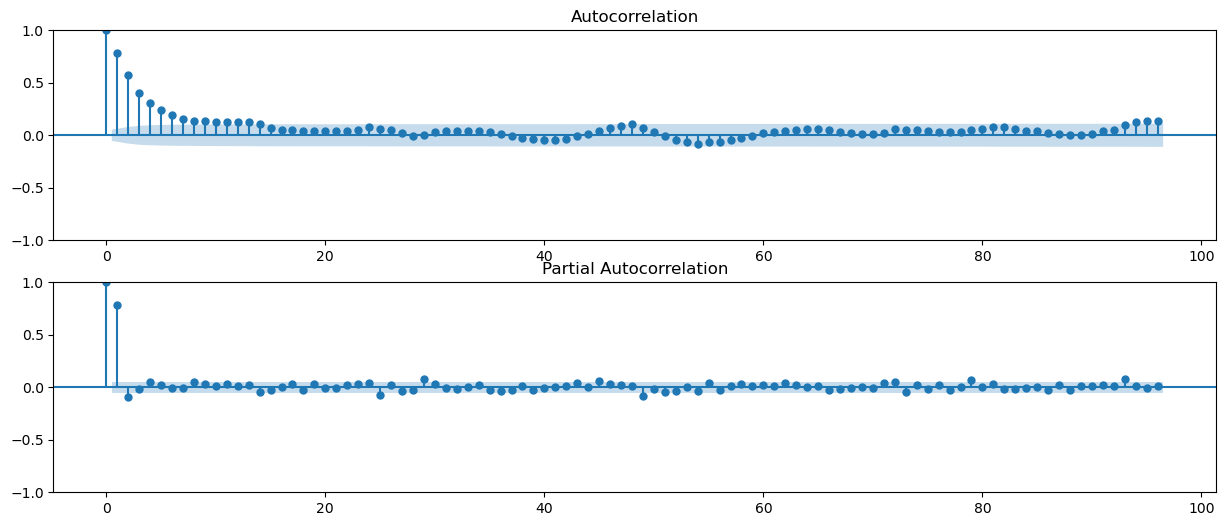

In [35]:
nlags = 96 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y_week, lags = nlags, ax=ax[0])
plot_pacf(y_week, lags = nlags, method="ols", ax=ax[1])
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33258D+00    |proj g|=  3.99834D-02


 This problem is unconstrained.



At iterate    5    f=  7.33080D+00    |proj g|=  1.84742D-02

At iterate   10    f=  7.32076D+00    |proj g|=  2.77588D-01

At iterate   15    f=  7.29336D+00    |proj g|=  1.64398D-01

At iterate   20    f=  7.27546D+00    |proj g|=  1.26928D-02

At iterate   25    f=  7.27458D+00    |proj g|=  3.16018D-03

At iterate   30    f=  7.27457D+00    |proj g|=  1.08010D-03

At iterate   35    f=  7.27337D+00    |proj g|=  1.45344D-02

At iterate   40    f=  7.27153D+00    |proj g|=  4.06713D-02
  ys=-1.897E-04  -gs= 1.963E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     72      1     1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                     SARIMAX Results                                      
Dep. Variable:                        niv_outturn   No. Observations:                 1345
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 48)   Log Likelihood               -9779.931
Date:                            Thu, 05 Dec 2024   AIC                          19571.862
Time:                                    13:50:16   BIC                          19603.082
Sample:                                09-02-2024   HQIC                         19583.556
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
demand_outturn    -0.0408      0.011     -3.831      0.000      -0.062      -0.020
ar.L1              0.78

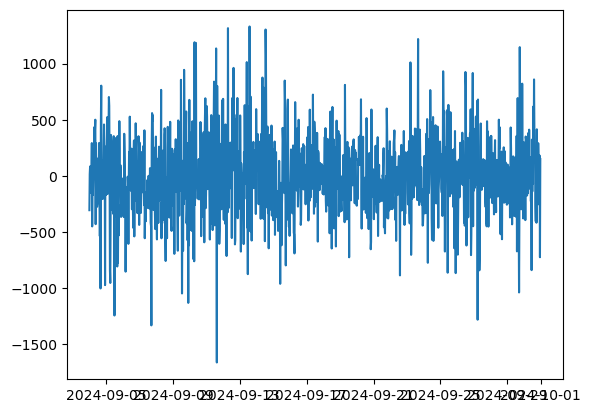

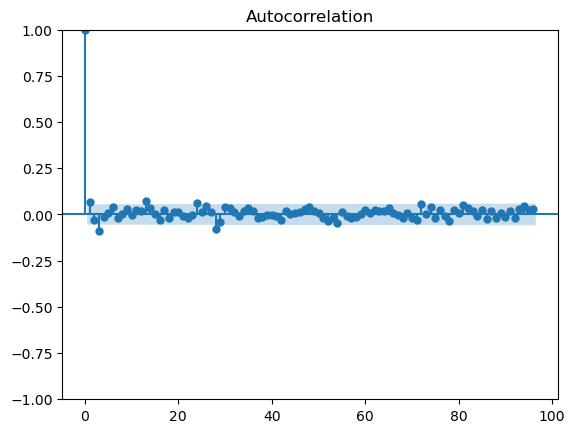

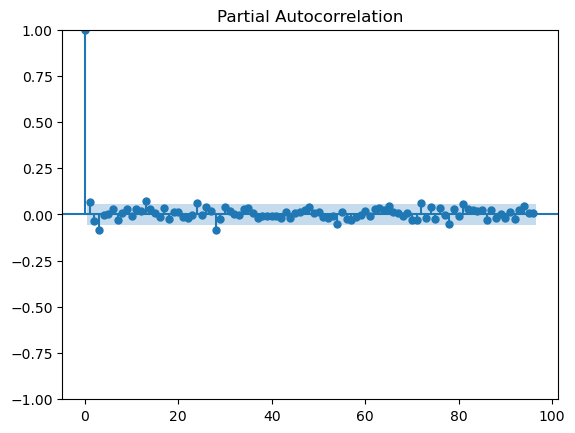

ADF Statistic: -22.604251088766617
p-value: 0.0
Critical Values:
   1%: -3.4354175403897727
   5%: -2.8637778952086848
   10%: -2.5679614713589562


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

s = 48

#fit = SARIMAX(endog = y_week, order = (2,0,0), seasonal_order = (0,0,0,s)).fit()
#fit = SARIMAX(endog = y_week, order = (3,0,1), seasonal_order = (0,0,0,s)).fit()
fit = SARIMAX(endog = y_week, exog = selected, order = (1,1,1), seasonal_order = (1,0,1,s)).fit()


print(fit.summary())
residuos = fit.resid[s+1:]

nlags=96

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()


# Run ADF test on the residuals
adf_test = sm.tsa.stattools.adfuller(residuos)

# Extract and print ADF test results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

In [37]:
# t-test for the mean with Ho equal to zero

t_statistic, p_value = stats.ttest_1samp(residuos, 0)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 0.3539873167494454
P-value: 0.7234060136189588


Ljung-Box for the residuals
       lb_stat  lb_pvalue
96  106.335915   0.221112
Shapiro test for residuals: Statistic value 0.9885828495025635 p-value 1.590583664778933e-08


/var/folders/fs/d_m9l_fs169d2k37mxblsk400000gn/T/ipykernel_51060/2134962675.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(residuos, hist = False, kde = True,
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


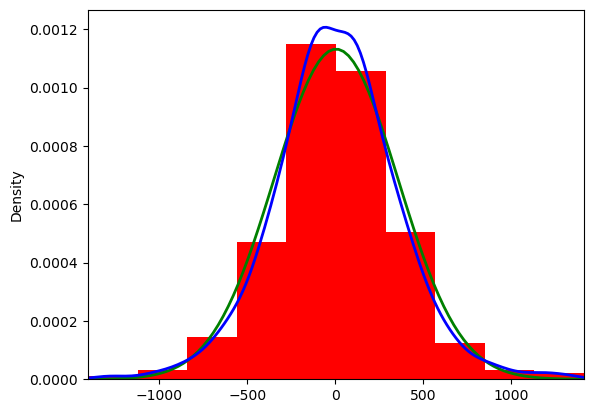

In [38]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[96])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

Ljung-Box for squared residuals
       lb_stat     lb_pvalue
96  232.836002  2.244411e-13


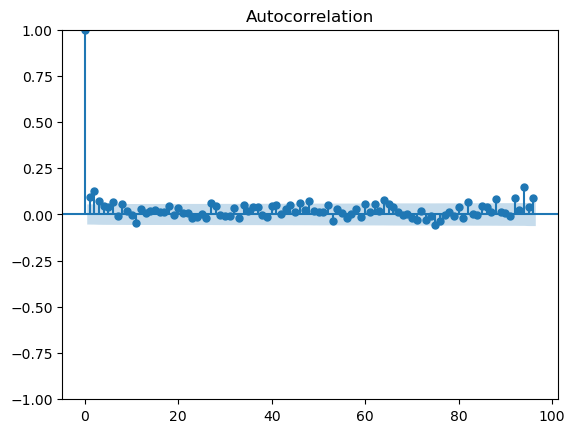

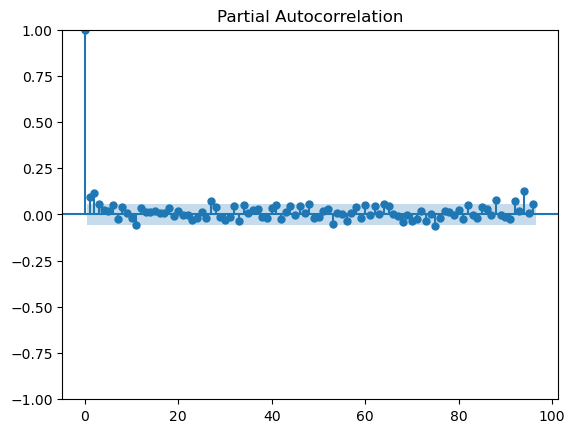

In [39]:
# Study the squared residuals for SWN

box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[96])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuos**2,lags=nlags)
plt.show()
plot_pacf(residuos**2,lags=nlags,method="ols")
plt.show()

In [40]:
y_pred = fit.forecast(steps = 48, exog = selected_48)
y_pred = pd.DataFrame(y_pred)

In [41]:
from arch import arch_model

#garch_model = arch_model(residuos, mean='constant', vol='ARCH', p=3)
garch_model = arch_model(residuos, mean='constant', vol='EGARCH', p=1, q=1)

garch_fit = garch_model.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 439494529.9098464
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12935.147964185606
Iteration:      3,   Func. Count:     21,   Neg. LLF: 707256341.6259608
Iteration:      4,   Func. Count:     27,   Neg. LLF: 707315337.1993477
Iteration:      5,   Func. Count:     33,   Neg. LLF: 269634796.07097507
Iteration:      6,   Func. Count:     41,   Neg. LLF: 707416570.3778458
Iteration:      7,   Func. Count:     49,   Neg. LLF: 375109920.28337187
Iteration:      8,   Func. Count:     57,   Neg. LLF: 439480500.63603115
Iteration:      9,   Func. Count:     65,   Neg. LLF: 707257761.8444427
Iteration:     10,   Func. Count:     71,   Neg. LLF: 706921433.6421399
Iteration:     11,   Func. Count:     78,   Neg. LLF: 686065577.2586517
Iteration:     12,   Func. Count:     84,   Neg. LLF: 705578053.096209
Iteration:     13,   Func. Count:     91,   Neg. LLF: 9419.389631285227
Iteration:     14,   Func. Count:     97,   Neg. LLF: 9417.88

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.242e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -9408.89
Distribution:                  Normal   AIC:                           18825.8
Method:            Maximum Likelihood   BIC:                           18846.4
                                        No. Observations:                 1296
Date:                Thu, Dec 05 2024   Df Residuals:                     1295
Time:                        13:50:19   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -4.2721      9.256     -0.462      0.644 [-22.413, 13.869]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.5192      1.151      2.189  2.863e-02 [  0.263,  4.775]
alpha[1]       0.2987  6.116e-02      4.884  1.040e-06 [  0.179,  0.419]
beta[1]        0.7851  9.845e-02      7.974  1.530e-15 [  0.592,  0.978]
========================================================================

Covariance estimator: robust
"""

In [42]:
y_pred_series = y_pred.iloc[:, 0]  # Use the first column of the DataFrame
# Forecast for the next 10 steps
garch_forecast = garch_fit.forecast(horizon=48, method='simulation')

# Access the mean and variance forecasts
garch_residual_forecast = garch_forecast.mean.iloc[-1].values  # Forecasted mean
garch_variance_forecast = garch_forecast.variance.iloc[-1].values  # Forecasted variance

# Compute the volatility forecast if needed (square root of variance)
volatility_forecast = np.sqrt(garch_variance_forecast)

# Final combined forecast (SARIMA + GARCH)
final_forecast_NIV = y_pred_series + garch_residual_forecast

# Print outputs
print("SARIMA Forecast:", y_pred_series)
print("GARCH Residual Forecast (Mean):", garch_residual_forecast)
print("GARCH Volatility Forecast:", volatility_forecast)
print("Final Combined Forecast:", final_forecast)

SARIMA Forecast: 2024-10-01 00:00:00   -226.302890
2024-10-01 00:30:00   -133.836685
2024-10-01 01:00:00   -118.544403
2024-10-01 01:30:00    -77.082031
2024-10-01 02:00:00    -31.605742
2024-10-01 02:30:00     32.712316
2024-10-01 03:00:00     61.294095
2024-10-01 03:30:00    134.007245
2024-10-01 04:00:00    130.816408
2024-10-01 04:30:00    171.796009
2024-10-01 05:00:00     70.580734
2024-10-01 05:30:00    -58.166055
2024-10-01 06:00:00   -200.634208
2024-10-01 06:30:00   -419.213309
2024-10-01 07:00:00   -272.680526
2024-10-01 07:30:00   -277.772961
2024-10-01 08:00:00   -358.337272
2024-10-01 08:30:00   -289.331735
2024-10-01 09:00:00   -269.767432
2024-10-01 09:30:00   -176.215178
2024-10-01 10:00:00   -229.083055
2024-10-01 10:30:00   -234.763546
2024-10-01 11:00:00   -274.135692
2024-10-01 11:30:00   -289.581594
2024-10-01 12:00:00   -316.284106
2024-10-01 12:30:00   -248.072853
2024-10-01 13:00:00   -197.987716
2024-10-01 13:30:00   -200.334074
2024-10-01 14:00:00   -141.6062

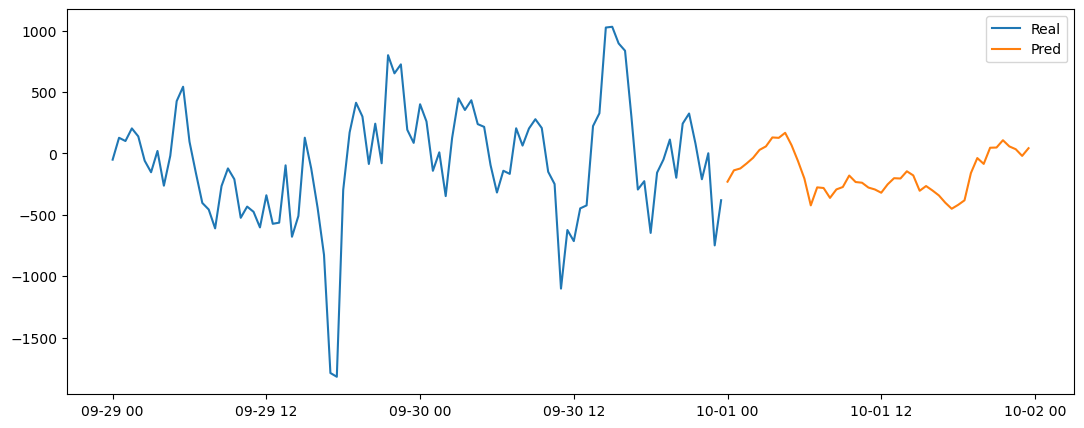

In [43]:
# Keep only the last 96 entries
y_last_96 = y.iloc[-96:]
y_pred_last_96 = final_forecast_NIV

# Plot the shortened data
plt.figure(figsize=(13, 5))
plt.plot(y_last_96, label='Real')
plt.plot(y_pred_last_96, label='Pred')
plt.legend()
plt.show()

In [44]:
final_forecast['NIV_Outturn'] = final_forecast_NIV
final_forecast.to_csv('combined_forecast.csv', index=True)  # index=False excludes the index column